In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import seaborn as sns
import math

folder = '../Data/test/images'

for filename in os.listdir(folder):
    print(filename)

for filename in os.listdir(folder):
    img = cv.imread(os.path.join(folder,filename))
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret,thresh = cv.threshold(img,100,255,cv.THRESH_BINARY_INV)
    img_name = filename.replace("rgb", "msk")
    cv.imwrite(f"../Data/test/masks/{img_name}", thresh)

In [2]:
#img = cv.imread('wire.jpg')
img = cv.imread('../Data/sample images/3.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img, (400, 400))

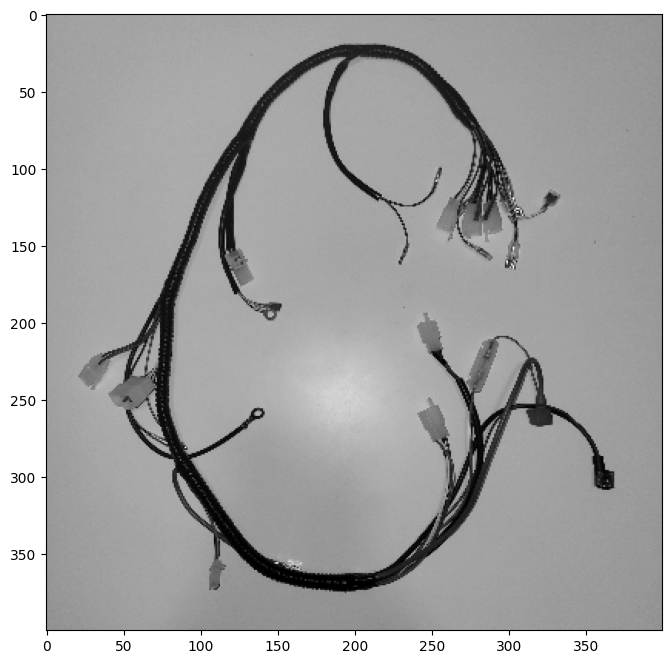

In [3]:
plt.subplots(figsize=(10,8)),plt.imshow(img, 'gray', vmin=0, vmax=255)
plt.show()

In [4]:
_,thresh2 = cv.threshold(img,100,255,cv.THRESH_BINARY_INV)

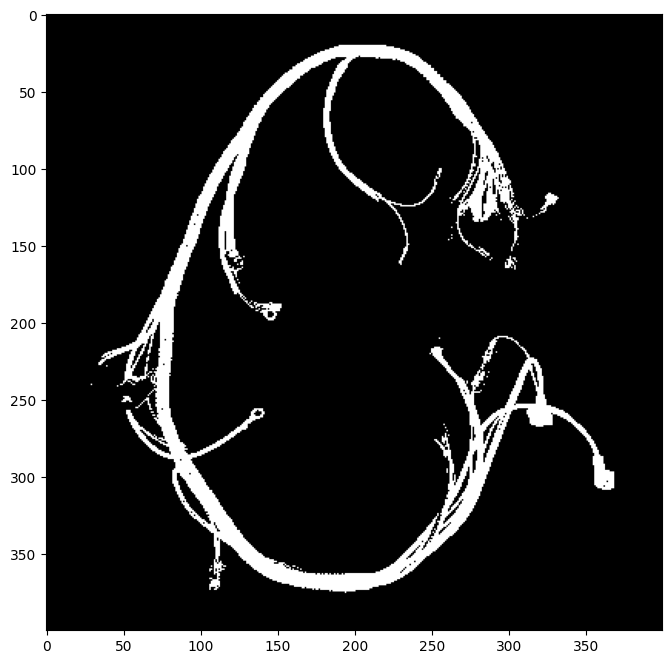

In [5]:
plt.subplots(figsize=(10,8)),plt.imshow(thresh2, 'gray')
plt.show()

contours, _= cv.findContours(thresh2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

len(contours)

contours_clean = []
for c in contours:
    area = cv.contourArea(c)
    if area > 5.0:
        contours_clean.append(c)

len(contours_clean)

cont_index = np.array(areas).argmax()
wire_cont = contours[cont_index]

#new_mask = cv.drawContours(thresh2, [wire_cont], -1, color=(255, 255, 255), thickness=cv.FILLED)
new_mask = cv.drawContours(thresh2, contours_clean, -1, color=(255, 255, 255), thickness=cv.FILLED)

plt.subplots(figsize=(10,8)),plt.imshow(new_mask, 'gray')
plt.show()

In [6]:
points = np.transpose(np.nonzero(thresh2))

In [7]:
points

array([[ 20, 190],
       [ 20, 191],
       [ 20, 192],
       ...,
       [374, 199],
       [374, 200],
       [375, 194]], dtype=int64)

In [8]:
knn_graph = kneighbors_graph(points, 40, include_self=False)

In [9]:
clustering = AgglomerativeClustering(n_clusters=40, linkage="ward", connectivity=knn_graph)

In [10]:
clustering.fit(points)

AgglomerativeClustering(connectivity=<12577x12577 sparse matrix of type '<class 'numpy.float64'>'
	with 503080 stored elements in Compressed Sparse Row format>,
                        n_clusters=40)

In [11]:
clustering.labels_

array([ 2,  2,  2, ..., 27, 27, 27], dtype=int64)

In [12]:
df = pd.DataFrame(points)
df['cluster'] = clustering.labels_
df.columns = ['Y', 'X', 'clusters']
df['Y'] = (df['Y'] * (-1)) + 400

In [13]:
df

,Y,X,clusters
0,380,190,2
1,380,191,2
2,380,192,2
3,380,193,2
4,380,194,2
...,...,...,...
12572,26,197,27
12573,26,198,27
12574,26,199,27
12575,26,200,27


In [14]:
df['clusters'].unique()

array([ 2, 12, 29, 20, 15,  9,  3, 13, 25, 11, 37, 34, 23, 32, 28, 14, 16,
       36, 10, 30,  1,  5, 38, 19, 18,  0,  6, 26,  8,  7, 21, 33, 31, 17,
       22,  4, 39, 35, 27, 24], dtype=int64)

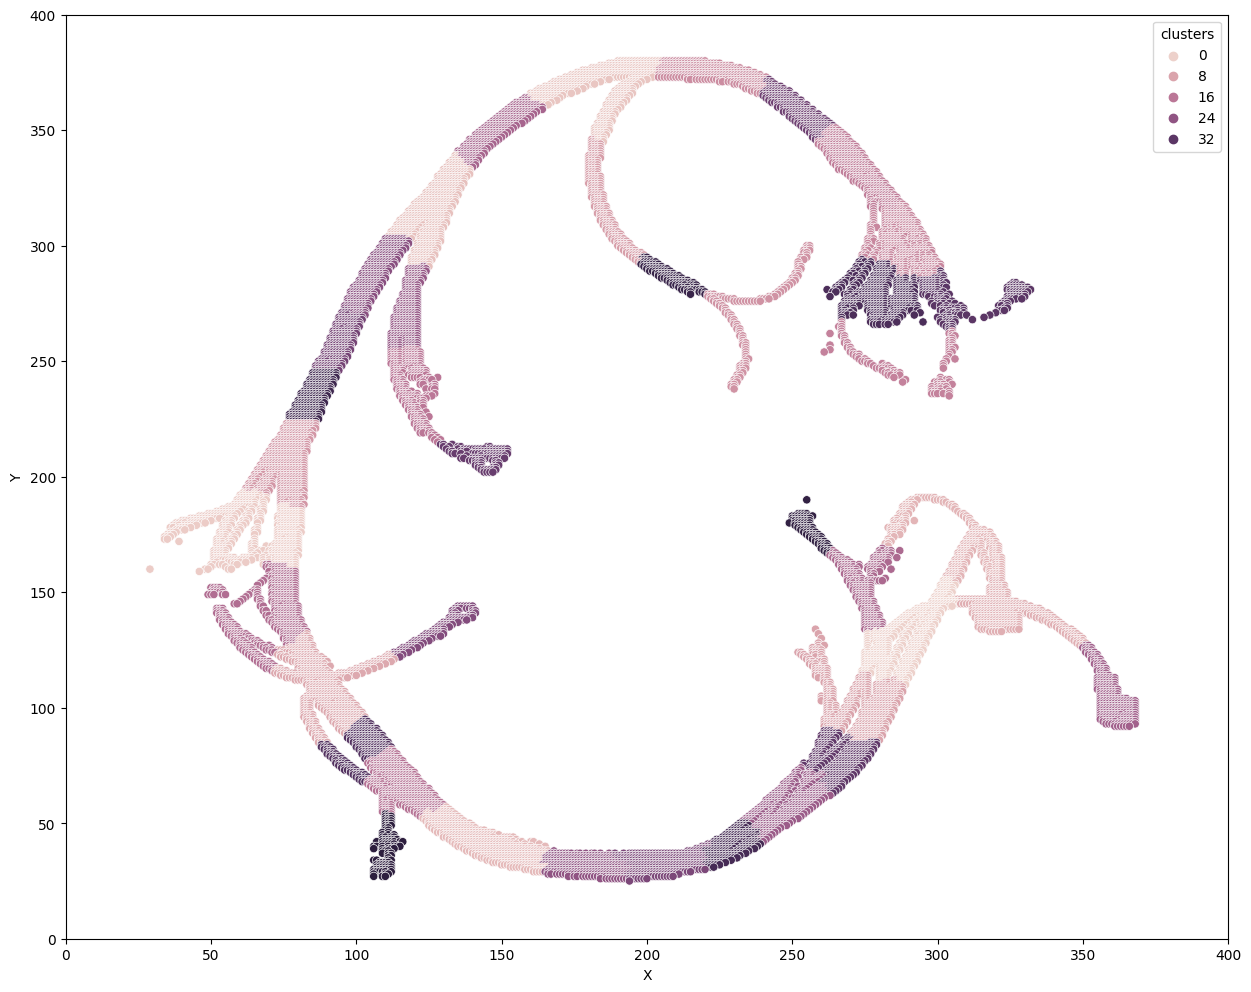

In [15]:
fig,ax = plt.subplots(figsize=(15,12))
sns.scatterplot(data=df, x="X", y='Y', hue="clusters", ax=ax)
_=ax.set_xlim(0,400)
_=ax.set_ylim(0,400)

In [16]:
df_points = df.groupby('clusters').agg({'X':[np.mean], 'Y':[np.mean]}).reset_index()

In [17]:
df_points.columns = ['cluster', 'X', 'Y']
df_points = df_points.apply(round)
df_points['Y'] = df_points['Y']
df_points

,cluster,X,Y
0,0,289.0,130.0
1,1,64.0,176.0
2,2,184.0,368.0
3,3,126.0,314.0
4,4,145.0,42.0
5,5,307.0,171.0
6,6,325.0,141.0
7,7,89.0,109.0
8,8,273.0,102.0
9,9,186.0,319.0


In [18]:
points_list = list(df_points[['X', 'Y']].itertuples(index=False, name=None))

In [19]:
for i in range(len(points_list)):
    cluster_df = df.loc[df['clusters'] == i]
    cluster_list = list(cluster_df[['X', 'Y']].itertuples(index=False, name=None))
    dist_list = []
    for pt in cluster_list:
        dist_list.append(math.dist(points_list[i], pt))
    idx = dist_list.index(min(dist_list))
    points_list[i] = cluster_list[idx]

In [20]:
list_sorted = [points_list[0]]
points_list.remove(points_list[0])

In [21]:
flag = True

while flag:
    point1 = list_sorted[-1]
    distances = []
    points = []
    
    for point2 in points_list:
        distance = math.dist(point1, point2)
        distances.append(distance)
        points.append(point2)
        
    min_dist_1 = min(distances)
    min_idx_1 = distances.index(min_dist_1)
    
    list_sorted.append(points[min_idx_1])
    points_list.remove(points[min_idx_1])
    
    if not points_list:
        flag = False

In [22]:
distances_list = []
for i in range(len(list_sorted)):
    print(list_sorted[i])
    if not i == (len(list_sorted) - 1):
        dist = math.dist(list_sorted[i], list_sorted[i+1])
        distances_list.append(dist)

(289, 130)
(275, 153)
(256, 177)
(309, 171)
(325, 141)
(360, 105)
(272, 102)
(266, 78)
(249, 59)
(229, 40)
(206, 33)
(179, 32)
(145, 42)
(109, 39)
(116, 66)
(102, 83)
(89, 109)
(70, 140)
(65, 176)
(76, 205)
(85, 234)
(94, 258)
(118, 271)
(106, 287)
(126, 314)
(149, 350)
(182, 370)
(223, 374)
(252, 359)
(273, 333)
(288, 300)
(280, 279)
(308, 274)
(287, 245)
(237, 276)
(208, 287)
(185, 319)
(117, 239)
(143, 209)
(128, 134)


In [23]:
distances = pd.Series(distances_list.copy())
distances

0      26.925824
1      30.610456
2      53.338541
3      34.000000
4      50.209561
5      88.051122
6      24.738634
7      25.495098
8      27.586228
9      24.041631
10     27.018512
11     35.440090
12     36.124784
13     27.892651
14     22.022716
15     29.068884
16     36.359318
17     36.345564
18     31.016125
19     30.364453
20     25.632011
21     27.294688
22     20.000000
23     33.600595
24     42.720019
25     38.587563
26     41.194660
27     32.649655
28     33.421550
29     36.249138
30     22.472205
31     28.442925
32     35.805028
33     58.830264
34     31.016125
35     39.408121
36    104.995238
37     39.698866
38     76.485293
dtype: float64

In [24]:
distances.mean()

37.568054731450964

In [25]:
threshold = distances.mean() + distances.std()
threshold

55.25094066233241

In [26]:
first_pt_idx = distances_list.index(distances.loc[distances > threshold].iloc[0])
first_pt_idx

5

In [27]:
list_sorted[first_pt_idx]

(360, 105)

In [28]:
list_sorted2 = [list_sorted[first_pt_idx]]
list_sorted.remove(list_sorted[first_pt_idx])
node_points = []

In [29]:
flag = True

while flag:
    point1 = list_sorted2[-1]
    distances = []
    points = []
    
    for point2 in list_sorted:
        distance = math.dist(point1, point2)
        distances.append(distance)
        points.append(point2)
        
    min_idx_1 = distances.index(min(distances))
    
    list_sorted2.append(points[min_idx_1])
    list_sorted.remove(points[min_idx_1])
    
    if not list_sorted:
        flag = False

In [30]:
for pt in list_sorted2:
    print(pt)

(360, 105)
(325, 141)
(309, 171)
(275, 153)
(289, 130)
(272, 102)
(266, 78)
(249, 59)
(229, 40)
(206, 33)
(179, 32)
(145, 42)
(109, 39)
(116, 66)
(102, 83)
(89, 109)
(70, 140)
(65, 176)
(76, 205)
(85, 234)
(94, 258)
(118, 271)
(106, 287)
(126, 314)
(149, 350)
(182, 370)
(223, 374)
(252, 359)
(273, 333)
(288, 300)
(280, 279)
(308, 274)
(287, 245)
(237, 276)
(208, 287)
(185, 319)
(117, 239)
(143, 209)
(128, 134)
(256, 177)


In [31]:
distances_list = []
for i in range(len(list_sorted2)):
    if not i == (len(list_sorted2) - 1):
        dist = math.dist(list_sorted2[i], list_sorted2[i+1])
        distances_list.append(dist)

In [32]:
distances_list = pd.Series(distances_list)
distances_list

0      50.209561
1      34.000000
2      38.470768
3      26.925824
4      32.756679
5      24.738634
6      25.495098
7      27.586228
8      24.041631
9      27.018512
10     35.440090
11     36.124784
12     27.892651
13     22.022716
14     29.068884
15     36.359318
16     36.345564
17     31.016125
18     30.364453
19     25.632011
20     27.294688
21     20.000000
22     33.600595
23     42.720019
24     38.587563
25     41.194660
26     32.649655
27     33.421550
28     36.249138
29     22.472205
30     28.442925
31     35.805028
32     58.830264
33     31.016125
34     39.408121
35    104.995238
36     39.698866
37     76.485293
38    135.029626
dtype: float64

In [33]:
distances_list.mean() 

38.446438181536635

In [34]:
branches = distances_list.loc[distances_list > (distances_list.mean() + 2*distances_list.std())]
branches

35    104.995238
38    135.029626
dtype: float64

In [35]:
branches_list = []
for i in range(len(branches.index)):
    if not i == (len(branches.index) - 1):
        first = branches.index[i] + 1
        last = branches.index[i+1] + 1
        
        branches_list.append(pd.DataFrame(list_sorted2[first : last], columns=['X', 'Y']))
    else:
        first = branches.index[i] + 1
        branches_list.append(pd.DataFrame(list_sorted2[first :], columns=['X', 'Y']))

In [36]:
branches_list

[     X    Y
 0  117  239
 1  143  209
 2  128  134,
      X    Y
 0  256  177]

In [37]:
df_points = pd.DataFrame(list_sorted2, columns=['X', 'Y'])

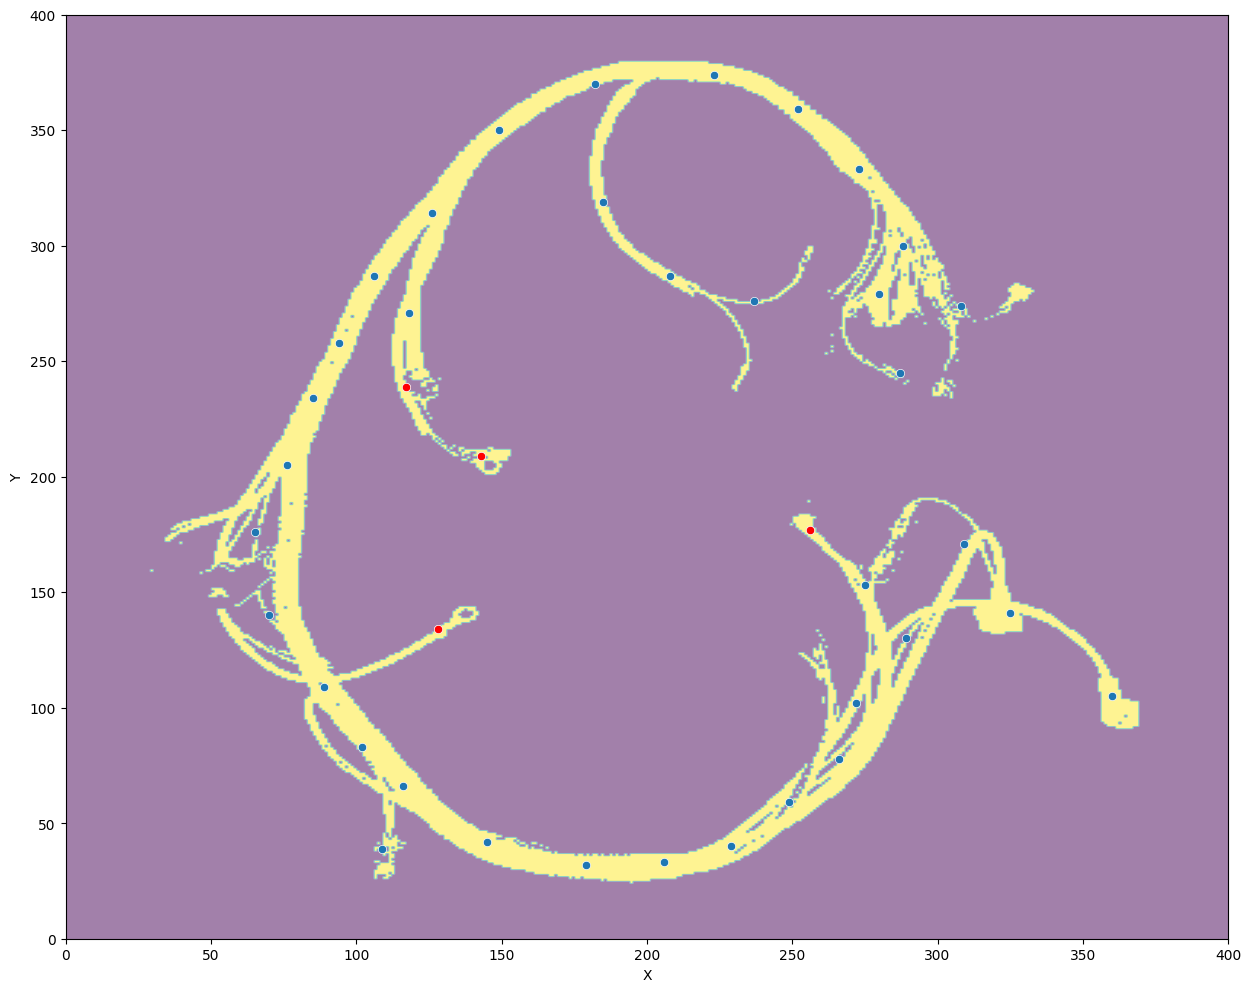

In [38]:
fig,ax = plt.subplots(figsize=(15,12))
plt.xlim(0, 400)
plt.ylim(0, 400)
#plt.axis('off')
sns.scatterplot(data=df_points, x="X", y='Y', ax=ax)
for dataset in branches_list:
    sns.scatterplot(data=dataset, x="X", y='Y', ax=ax, color='r')
ax.imshow(thresh2, extent=[0, 400, 0, 400], aspect='auto', alpha=0.5)
#plt.savefig('../Data/sample results/1.jpg')